### Plot Percent replicating for Spheroid Aggregated data

In [32]:
import pandas as pd
import numpy as np
import os

# Grit scores
import random

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("white")


# Set a random seed
import random
rng = np.random.RandomState(123)

# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1')
print(os.getcwd())

/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1
/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1


In [33]:
# Load some utilities from this repository: 

def percent_score(null_dist, corr_dist, how='right'):
    """
    Calculates the Percent replicating
    :param null_dist: Null distribution
    :param corr_dist: Correlation distribution
    :param how: "left", "right" or "both" for using the 5th percentile, 95th percentile or both thresholds
    :return: proportion of correlation distribution beyond the threshold
    From REF: https://github.com/carpenter-singh-lab/2023_Cimini_NatureProtocols/blob/main/notebooks/utils.py
    """
    if how == 'right':
        perc_95 = np.nanpercentile(null_dist, 95)
        above_threshold = corr_dist > perc_95
        return 100 * np.mean(above_threshold.astype(float)), perc_95
    if how == 'left':
        perc_5 = np.nanpercentile(null_dist, 5)
        below_threshold = corr_dist < perc_5
        return 100 * np.mean(below_threshold.astype(float)), perc_5
    if how == 'both':
        perc_95 = np.nanpercentile(null_dist, 95)
        above_threshold = corr_dist > perc_95
        perc_5 = np.nanpercentile(null_dist, 5)
        below_threshold = corr_dist < perc_5
        return 100 * (np.mean(above_threshold.astype(float)) + np.mean(below_threshold.astype(float))), perc_95, perc_5
    
def corr_between_replicates(df, group_by_feature):
    """
    Calculate the correlation between replicates
    From REF: https://github.com/carpenter-singh-lab/2023_Cimini_NatureProtocols/blob/main/notebooks/utils.py
    """
    replicate_corr = []
    replicate_grouped = df.groupby(group_by_feature)
    for name, group in replicate_grouped:
        group_features = get_featuredata(group)
        corr = np.corrcoef(group_features)
        if len(group_features) == 1:  # If there is only one replicate on a plate
            replicate_corr.append(np.nan)
        else:
            np.fill_diagonal(corr, np.nan)
            replicate_corr.append(np.nanmedian(corr))  # median replicate correlation
    return replicate_corr

def corr_between_non_replicates(df, n_samples, n_replicates, metadata_compound_name):
    """
    Null distribution between random "replicates".
    :param df: pandas.DataFrame
    :param n_samples: int
    :param n_replicates: int
    :param metadata_compound_name: Compound name feature
    :return: list-like of correlation values, with a  length of `n_samples`
    """
    df.reset_index(drop=True, inplace=True)
    null_corr = []
    random.seed(42)
    while len(null_corr) < n_samples:
        compounds = random.choices([_ for _ in range(len(df))], k=n_replicates)
        sample = df.loc[compounds].copy()
        if len(sample[metadata_compound_name].unique()) == n_replicates:
            sample_features = get_featuredata(sample)
            corr = np.corrcoef(sample_features)
            np.fill_diagonal(corr, np.nan)
            null_corr.append(np.nanmedian(corr))  # median replicate correlation
    return null_corr

def get_featuredata(df):
    """return dataframe of just featuredata columns"""
    return df[get_featurecols(df)]

def get_featurecols(df):
    """return a list of featuredata columns"""
    return [c for c in df.columns if not "Metadata" in c]

def list_features(df):
    # List features
    list_of_selected_features = list(df.columns.values)
    list_of_metadata = list(df.columns[df.columns.str.contains("Metadata_")])
    list_of_selected_features = list(set(list_of_selected_features) - set(list_of_metadata))
    
    return list_of_selected_features, list_of_metadata

def process_correlation_data(df, perturbation):
    data = get_featuredata(df).groupby(df[perturbation]).mean()
    correlations = corr_between_replicates(df, perturbation)
    corr_dist = pd.DataFrame({perturbation: data.index, 'corr': correlations})
    corr_dist[[cmpd_short_name, cmpd_conc]] = corr_dist[perturbation].str.split("_", expand=True)
    # corr_dist[cmpd_conc] = corr_dist[cmpd_conc].astype(float)
    return corr_dist

In [34]:
# Set some metadata
perturbation = 'Metadata_pert_name'
cmpd_conc = 'Metadata_conc_step' # Use the step here to compare the different concentrations
cmpd_short_name = 'Metadata_name'

# Set the cell line and data type
cell_line = 'HCT116'
data_type = 'aggregates'


In [35]:
# Set up the plotting parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
dpi = 300
figformat = 'pdf'

In [36]:
# cell_lines = ['HCT116', 'HT29']
cell_lines = ['HCT116']
data_type = 'aggregates'

In [37]:
# Load the data
dir = '1_Data/results/'
data =  pd.read_parquet(('{}selected_data_{}_{}.parquet').format(dir, data_type, cell_line))

In [38]:
# Load the data
dir = '1_Data/results/'
# data =  pd.read_parquet(('{}grit_data_{}_{}.parquet').format(dir, data_type, cell_line))
# data =  pd.read_parquet(('{}grit_data_test10.parquet').format(dir, data_type, cell_line))
# data =  pd.read_parquet(('{}grit_data_test3.parquet').format(dir, data_type, cell_line))
# data =  pd.read_parquet(('{}grit_data_test4.parquet').format(dir, data_type, cell_line))
data.dropna(axis='columns', how='all', inplace=True)

dataset_pr = data.copy()

### Percent Replicating

In [39]:
perc_replicating = []

null_dist_all = pd.DataFrame()
corr_dist_all = pd.DataFrame()

for cell_line in cell_lines:
    print(cell_line)
    
    ## Prepare metadata for the calculation
    dataset_pr  = pd.read_parquet(('{}grit_data_{}_{}.parquet').format(dir, data_type, cell_line))
    dataset_pr = dataset_pr.dropna(axis='columns', how='all')

    # Add a column with the step of the concentration (easier for plotting)
    dataset_pr['Metadata_conc_step'] = (
        dataset_pr.groupby('Metadata_cmpdname')['Metadata_cmpd_conc'].rank(ascending=True, method='dense')
        )
    # Add a column with the name of the perturbation (compound + concentration)
    dataset_pr["Metadata_pert_name"] = (
        dataset_pr["Metadata_name"] + "_" + dataset_pr["Metadata_conc_step"].astype(str)
        )

    dataset_pr = dataset_pr[dataset_pr['Metadata_pert_type'] == 'trt']


    # Calculate percent replicating per concentration
    concentrations = dataset_pr[cmpd_conc].unique()
    concentrations.sort()



    for conc in concentrations:

        conc_df = dataset_pr.loc[dataset_pr[cmpd_conc] == conc]

        # Settings
        n_replicates = 4 # 4 replicates each
        n_compounds = 52
        n_samples = n_compounds * n_replicates

        # Calculate the null distribution
        null_dist = corr_between_non_replicates(conc_df, n_samples, n_replicates, perturbation)
        corr_dist_cmpds = process_correlation_data(conc_df, perturbation)

        perc_repl, perc_95 = percent_score(null_dist, corr_dist_cmpds['corr'], how='right')
        
        perc_replicating.append(perc_repl)

        tmp = pd.DataFrame(null_dist, columns=['corr'])
        tmp['Metadata_conc_step'] = conc
        tmp['cell_line'] = cell_line
        corr_dist_cmpds['cell_line'] = cell_line

        null_dist_all = pd.concat([null_dist_all,tmp], axis=0)
        corr_dist_all = pd.concat([corr_dist_all,corr_dist_cmpds], axis=0)

    pr = pd.DataFrame({'data':'xxx', 'cmpd_conc':concentrations, 'perc_replicating':perc_replicating, 'cell_line':cell_line})
    # pd.DataFrame(perc_replicating).to_csv("{}/perc_replicating_conc_{}.csv".format(BaseDir,cell_line))


HCT116


In [40]:
pr

,data,cmpd_conc,perc_replicating,cell_line
0,xxx,1.0,44.230769,HCT116
1,xxx,2.0,55.769231,HCT116
2,xxx,3.0,64.705882,HCT116
3,xxx,4.0,67.391304,HCT116


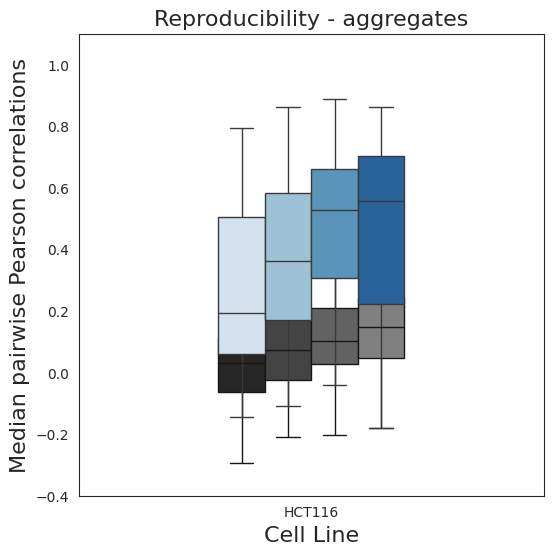

In [41]:
# Plot the data in a boxplot
corr_dist_all = corr_dist_all.reset_index(drop=True)
null_dist_all=null_dist_all.reset_index(drop=True)


fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=null_dist_all, x='cell_line', y='corr', width=0.4, hue='Metadata_conc_step', palette='dark:grey', fill=True,  fliersize=1, showfliers=False, legend=False)
sns.boxplot(data=corr_dist_all, x='cell_line', y='corr', ax=ax, width=0.4, hue='Metadata_conc_step', palette='Blues', fill=True, fliersize=1, showfliers=False, legend=False)

ax.set_xlabel('Cell Line', fontsize=16)
ax.set_ylabel('Median pairwise Pearson correlations', fontsize=16)
ax.set_ylim(-0.4, 1.1)

plt.title('Reproducibility - ' + data_type, fontsize=16)
plt.show()

# fig.savefig(
#         "3_Figure3/PercentReplicating/result-images/PercentReplicating_{}.{}".format(data_type, figformat), dpi=dpi, bbox_inches="tight"
#         )